<a href="https://colab.research.google.com/github/3-Ada/intel_image_classification/blob/main/intel_image_classification_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# Step 0: import dataset

In [6]:
from google.colab import files # library for working with files
files.upload() # upload kaggle.json from pc

!pip install -q kaggle # install kaggle API client
! mkdir ~/.kaggle # create folder with name .kaggle
! cp kaggle.json ~/.kaggle/ # move kaggle.json to created directory
! chmod 600 /root/.kaggle/kaggle.json # change permissions to more secure
! kaggle datasets download -d puneet6060/intel-image-classification


Saving kaggle.json to kaggle.json
100% 346M/346M [00:16<00:00, 23.4MB/s]
100% 346M/346M [00:16<00:00, 21.4MB/s]


In [7]:
%%capture
! mkdir /content/image_files
! unzip intel-image-classification.zip -d /content/image_files

# Step 1: Explore the dataset

**Problem statement:** the challenge is to create a robust image classification model that categorizes natural scene images into six distinct categories (buildings, forest, glacier, mountain, sea, street).

**The dataset** contains around 25k images of size 150x150.

In [8]:
train_dir = '/content/image_files/seg_train/seg_train'
valid_dir = '/content/image_files/seg_test/seg_test'

In [9]:
batch_size = 32
image_size = (150, 150)

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              target_size=image_size)

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1/255)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                        class_mode='categorical',
                                                        target_size=image_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


The dataset has been partitioned into three segments:

1.   Training Data: Approximately 14,000 images
2.   Testing Data: Around 3,000 images
3.   Prediction Data: Comprising about 7,000 images

The prediction dataset was not used in the model evaluation process due to the absence of labels.

Let's create dataset with images which will be used for training.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


In [7]:
class_names = train_ds.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

count = labels.value_counts().sort_index()
count.index = class_names

Text(0.5, 1.0, 'Amount of images in each category')

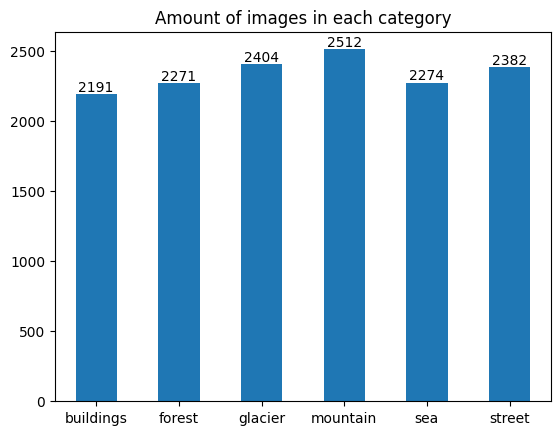

In [9]:
ax = count.plot(kind='bar', rot=0)
ax.bar_label(ax.containers[0])
ax.set_title("Amount of images in each category")

As we can see, the dataset is pretty balanced.

To better understand the dataset, let's plot examples from each category.

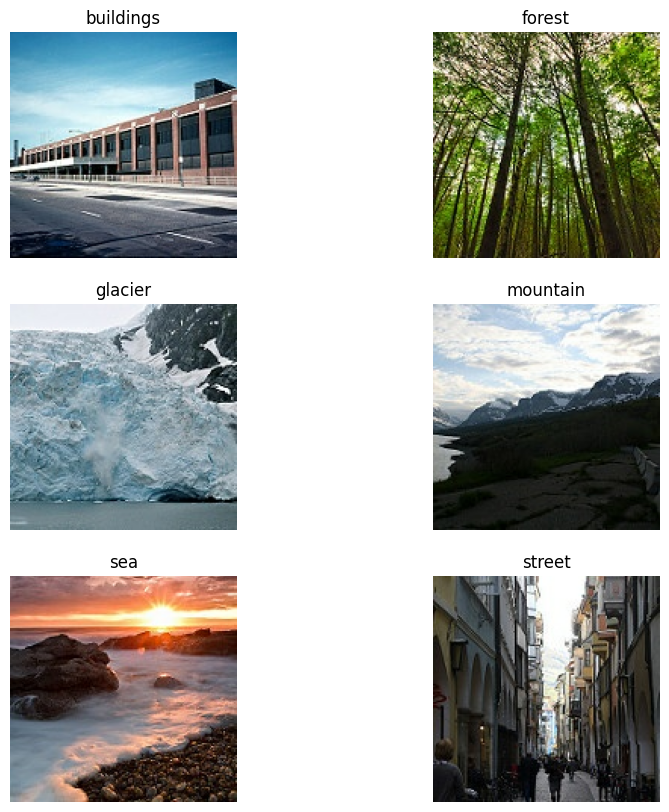

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        all_labels = range(6)
        target_label = all_labels[i]
        # Filter the dataset by label
        filtered_dataset = train_ds.take(1).unbatch().filter(lambda image, label: label == target_label)
        filtered_images = [image.numpy() for image, _ in filtered_dataset]
        plt.imshow(array_to_img(filtered_images[0]))
        plt.title(class_names[target_label])
        plt.axis("off")

# Step 2: Create model

I conducted a series of experiments to explore various model architectures suitable for addressing the image classification challenge. The best-performing model will be shown below.

The architecture can be broken down into the following components:

* Convolutional and Pooling Layers: 4 sets of convolutional layers, each followed by a max-pooling layer, to capture  features in the images. After each pair of these layers there is dropout layer to help to reduce overfitting.

* Flattening Layer: After the convolutional layers, there is Flatten layer to reshape the data for input into the dense layers.

* Dense Layers: A sequence of dense layers with varying sizes of hidden units. After these layers there is dropout layer to help to reduce overfitting.

* Output Layer: The final layer comprises 6 nodes, because dataset has 6 image categories.


The model is compiled with the following settings:

* Optimizer: The Adam optimizer is chosen for efficient gradient descent optimization.
* Loss Function: Categorical cross-entropy, appropriate for multi-class classification tasks.
* Metrics: The model's performance is evaluated using the accuracy metric, indicating the proportion of correctly classified images.

In [10]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer=tf.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [11]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [13]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator)

Epoch 1/30
439/439 [==============================] - 56s 83ms/step - loss: 1.5748 - accuracy: 0.3110 - val_loss: 1.0524 - val_accuracy: 0.5797
Epoch 2/30
439/439 [==============================] - 35s 80ms/step - loss: 0.9869 - accuracy: 0.5982 - val_loss: 0.9229 - val_accuracy: 0.6223
Epoch 3/30
439/439 [==============================] - 34s 78ms/step - loss: 0.8384 - accuracy: 0.6581 - val_loss: 0.7799 - val_accuracy: 0.6753
Epoch 4/30
439/439 [==============================] - 34s 78ms/step - loss: 0.7544 - accuracy: 0.7027 - val_loss: 0.7436 - val_accuracy: 0.7180
Epoch 5/30
439/439 [==============================] - 34s 78ms/step - loss: 0.6625 - accuracy: 0.7525 - val_loss: 0.7070 - val_accuracy: 0.7390
Epoch 6/30
439/439 [==============================] - 34s 78ms/step - loss: 0.5984 - accuracy: 0.7771 - val_loss: 0.7035 - val_accuracy: 0.7587
Epoch 7/30
439/439 [==============================] - 35s 79ms/step - loss: 0.5535 - accuracy: 0.7956 - val_loss: 0.5106 - val_accuracy:

The model correctly classified approximately **83%** of the images in the validation dataset.

Let's visualise the achieved results.

In [12]:
def plot_acc_loss(history):
    # Plot the chart for accuracy and loss on both training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

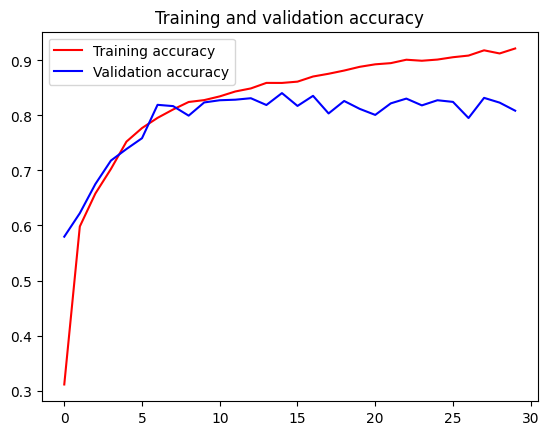

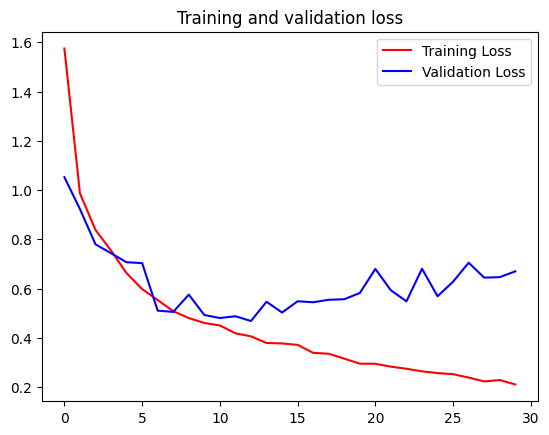

In [15]:
plot_acc_loss(history)

For dealing with overfitting and improving the accuracy of a model let's use data augmentation.

Augmenting techniques which were used: random rotation within 30 degrees,random zooming in or out by up to 10%, random flips images horizontally.

In [13]:
train_gen_augm = ImageDataGenerator(rescale=1/255,
                                    rotation_range=30,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

# Pass in the appropriate arguments to the flow_from_directory method
train_generator_augm = train_gen_augm.flow_from_directory(directory=train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=image_size)

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1/255)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                              class_mode='categorical',
                                                              target_size=image_size)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [14]:
history_augm = model.fit(train_generator_augm,
                    epochs=30,
                    validation_data=validation_generator)

Epoch 1/30
439/439 [==============================] - 124s 231ms/step - loss: 1.2352 - accuracy: 0.4848 - val_loss: 0.9750 - val_accuracy: 0.6037
Epoch 2/30
439/439 [==============================] - 104s 237ms/step - loss: 1.0010 - accuracy: 0.5931 - val_loss: 0.8450 - val_accuracy: 0.6687
Epoch 3/30
439/439 [==============================] - 101s 230ms/step - loss: 0.9175 - accuracy: 0.6366 - val_loss: 0.8804 - val_accuracy: 0.6517
Epoch 4/30
439/439 [==============================] - 110s 251ms/step - loss: 0.8560 - accuracy: 0.6712 - val_loss: 0.8480 - val_accuracy: 0.6837
Epoch 5/30
439/439 [==============================] - 119s 271ms/step - loss: 0.7783 - accuracy: 0.7084 - val_loss: 0.7293 - val_accuracy: 0.7343
Epoch 6/30
439/439 [==============================] - 110s 251ms/step - loss: 0.7318 - accuracy: 0.7292 - val_loss: 0.6240 - val_accuracy: 0.7717
Epoch 7/30
439/439 [==============================] - 109s 248ms/step - loss: 0.6728 - accuracy: 0.7556 - val_loss: 0.6801 -

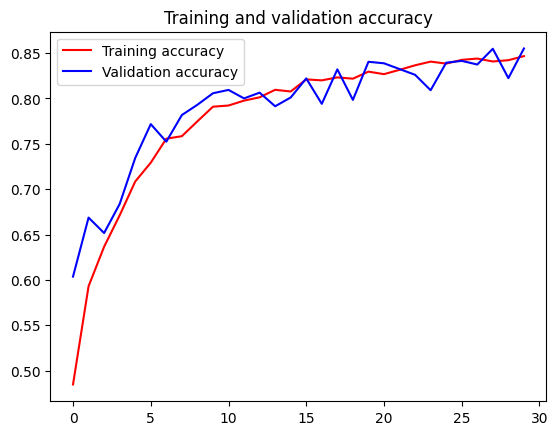

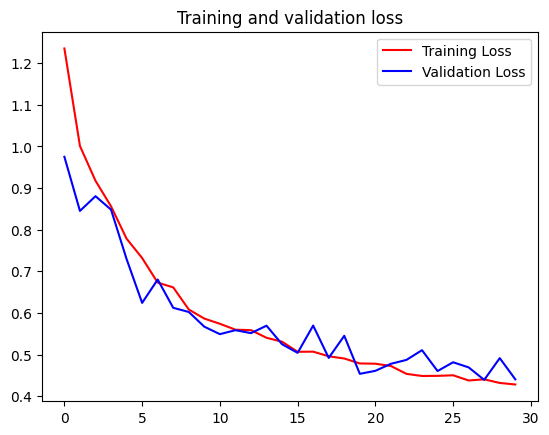

In [15]:
plot_acc_loss(history_augm)

We can observe improvements in the results, accompanied by a reduction in overfitting. Now the best result on validation dataset is **85%**.

# Further improvements

*   transfer learning can be used for improve the accuracy of the model.
*   experimets with various data augmentation methods.
*   experiments with hyperparameters, such as batch size and learning rate.

